Ekstrakcja cech na podstawie DWT i AR

In [85]:
import os

import numpy as np
import pandas as pd
import pywt
from biosppy.signals.ecg import ASI_segmenter, christov_segmenter
from statsmodels.tsa.ar_model import AutoReg

In [59]:
def extract_wavelet_features(ecg_signal, sampling_rate=500, heartbeat_len=500, wavelet='db8', ar_order=4):
    peaks = christov_segmenter(ecg_signal, sampling_rate)

    features = []
    for peak in peaks[0]:
        start = max(0, peak - heartbeat_len // 2)
        end = start + heartbeat_len

        if end > len(ecg_signal):
            break

        heartbeat = ecg_signal[start: end]
        coefficents = pywt.wavedec(heartbeat, wavelet, level=4)
        a4 = coefficents[0]
        a4 = a4[: min(len(a4), 32)]

        try:
            ar_model = AutoReg(heartbeat, lags=ar_order, old_names=False).fit()
            ar_coeffs = ar_model.params[1:]
        except ValueError:
            ar_coeffs = np.zeros(ar_order)

        if len(ar_coeffs) < ar_order:
            ar_coeffs = np.pad(ar_coeffs, (0, ar_order - len(ar_coeffs)), 'constant')

        peak_features = np.hstack([a4, ar_coeffs])
        features.append(peak_features)

    return np.array(features)

In [62]:
dataset = np.load('data/database_1_fft.npz')
ecg_signals = dataset['ecg']
labels = dataset['label']

In [60]:
extract_wavelet_features(ecg_signals[0, :])

array([[ 4.83953338e-01,  4.98667075e-01,  4.29713417e-01,
         5.69560924e-01,  4.51532377e-01,  4.60664486e-01,
         5.91306177e-01,  4.28795468e-01,  4.76094154e-01,
         5.99112539e-01,  2.87817771e-01,  8.28223338e-01,
        -8.38049914e-02, -4.55213775e-01,  1.51984030e-02,
         3.92935844e-02, -2.37652830e-02,  2.17064163e-02,
        -9.08650306e-03, -5.41335803e-03, -1.15457497e-02,
         7.58086652e-03, -5.30121278e-03,  5.60673459e-02,
        -1.78853542e-01,  2.57374138e-01,  6.92271982e-01,
        -5.32205118e-01, -2.74849209e-02,  8.16105655e-05,
        -6.51987632e-05,  9.00297635e-03,  2.42746035e+00,
        -2.43923115e+00,  1.44236076e+00, -4.58591961e-01],
       [ 3.25108878e-01,  3.58252041e-01,  4.68227035e-01,
         2.33078919e-01,  4.42542153e-01,  4.04118318e-01,
         1.76128149e-01,  4.70554074e-01,  3.93392844e-01,
         1.99750739e-01,  6.40640625e-01, -1.91710727e-02,
         1.05086087e+00, -3.50588934e-01, -2.09360832e-

In [64]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

ecg_features = [extract_wavelet_features(signal) for signal in tqdm(ecg_signals)]

  0%|          | 0/45152 [00:00<?, ?it/s]

In [106]:
n_pad_trunc_beats = 25
n_features = 36

processed = []
for sample in ecg_features:
    n_beats = sample.shape[0]
    if n_beats > n_pad_trunc_beats:
        processed.append(np.array(sample[:n_pad_trunc_beats]))
    else:
        pad_width = ((0, n_pad_trunc_beats - n_beats), (0, 0))
        processed.append(np.pad(sample, pad_width, mode='constant', constant_values=0))

processed = [np.array(sample) for sample in processed]
processed = np.array([sample.flatten() for sample in processed])
processed.shape

(45152, 900)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(processed, labels, stratify=labels, test_size=0.2)

In [97]:
processed_filename = 'data/wt_ar_features_36.npz'

if os.path.exists(processed_filename):
    loaded_dataset = np.load(processed_filename)
else:
    np.savez_compressed(processed_filename, ecg_features=processed)

In [139]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

random_state = 420
pipeline = Pipeline([
    ('pca', PCA(n_components=10, random_state=random_state)),
    ('classifier', SVC(C=65536,
                       gamma=0.000244,
                       class_weight='balanced', kernel='rbf', verbose=1, random_state=random_state)),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [140]:
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='balanced_accuracy', n_jobs=os.cpu_count() - 4,
                         verbose=1)
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  4.8min finished


[LibSVM]

Pipeline(steps=[('pca', PCA(n_components=10, random_state=420)),
                ('classifier',
                 SVC(C=65536, class_weight='balanced', gamma=0.000244,
                     random_state=420, verbose=1))])

In [141]:
print(f'Balanced accuracy: {scores.min() : .2f} - {scores.max() : .2f} ({scores.std() : .2f})')
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no arrhythmia', 'arrhythmia']))

Balanced accuracy:  0.82 -  0.83 ( 0.00)
               precision    recall  f1-score   support

no arrhythmia       0.35      0.91      0.50      1182
   arrhythmia       0.98      0.74      0.85      7849

     accuracy                           0.76      9031
    macro avg       0.66      0.82      0.67      9031
 weighted avg       0.90      0.76      0.80      9031



In [144]:
import joblib

joblib.dump(pipeline, 'models/svm_wt_ar.pkl')

['models/svm_wt_ar.pkl']

---

PCA covariance matrix
=====================

In [142]:
pca = pipeline.named_steps['pca']
explained_var = pca.explained_variance_ratio_
explained_var

array([0.41291905, 0.0946071 , 0.06527999, 0.06135999, 0.03686988,
       0.02420748, 0.02139222, 0.01662691, 0.01282269, 0.01098342])

Top 5 features for PC1: [array([465, 429, 501, 393, 537], dtype=int64)]


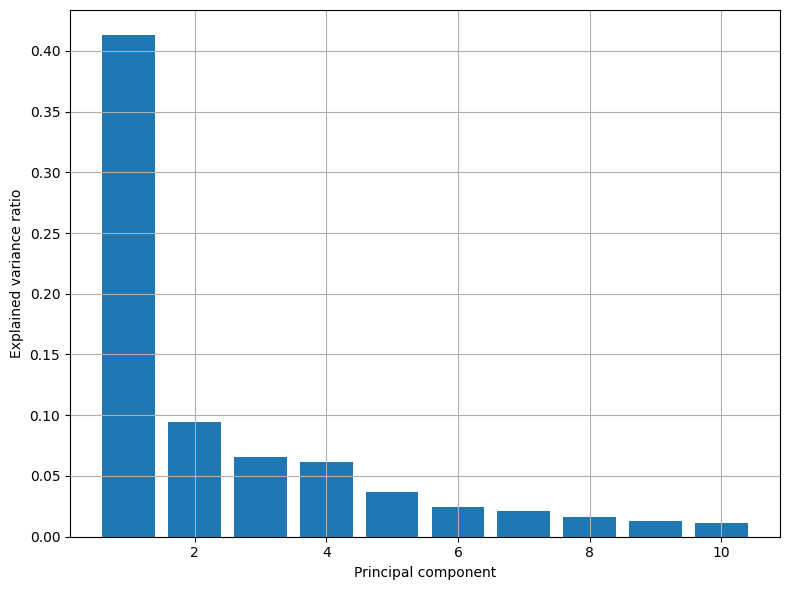

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_var) + 1), explained_var)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.grid()
plt.tight_layout()

loadings = pca.components_
n_top_features = 5
top_features = [loadings[0].argsort()[-n_top_features:][::-1]]

print(f'Top {n_top_features} features for PC1: {top_features}')

---

BalancedRandomForest param search
=================================

In [148]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

brf_pipeline = Pipeline([
    ('pca', PCA(random_state=random_state)),
    ('classifier', BalancedRandomForestClassifier(class_weight='balanced',
                                                  verbose=1,
                                                  n_jobs=4,
                                                  random_state=random_state)),
])

brf_grid = {
    'classifier__n_estimators': randint(5, 50),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

brf_rand_search = RandomizedSearchCV(
    brf_pipeline,
    param_distributions=brf_grid,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=cv,
    verbose=2,
    n_jobs=8,
    random_state=random_state
)

with joblib.parallel_backend('loky', n_jobs=8):
    brf_rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:   19.6s finished


In [149]:
brf_model = brf_rand_search.best_estimator_
brf_y_pred = brf_model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


In [152]:
print(classification_report(y_test, brf_y_pred))
print(brf_rand_search.best_params_)

              precision    recall  f1-score   support

           0       0.44      0.87      0.59      1182
           1       0.98      0.84      0.90      7849

    accuracy                           0.84      9031
   macro avg       0.71      0.85      0.74      9031
weighted avg       0.91      0.84      0.86      9031

{'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 30, 'classifier__n_estimators': 39}


In [153]:
joblib.dump(brf_model, 'brf_wt_ar.pkl')

['brf_wt_ar.pkl']